# Analyze Sorting

We now have a sorter and recording. Great! Now we can get on to the fun stuff: what shape are our unit templates? Which units are correlated with each other? Where on the probe are the units? This require computing extra information. In `SpikeInterface` we do this by creating an object called a `SortingAnalyzer`. 

A `SortingAnalyzer` combines a recording with a sorting in a unified way, no matter which sorter or recording format you used. Once you have an analyzer, you can compute postprocessing _extensions_ (like spike locations, waveforms, template metrics, ...) in exactly the same for every sorter. They can also be used to keep track of curation, merging and splitting, and more.

This unified framework has several benefits. The main one is that the analyzer defines a sorter-agnostic format for post-sorting analysis. Hence:
- You can compare sorters on a level playing field (i.e. all the extensions are computed in the same way, for all sorters)
- Your postprocessing pipeline can be identical, whether using mountainsort to sort tetrode data or kilosort to sort NeuroPixel data, creating a unified pipeline in your lab.
- External tools have a simple starting point to work from. This should make tooling in the community easier, and there are already several examples of this:
  - NeuronConv contains a `SortingAnalyzerToNWB` function
  - spikeinterface-gui, sortingview and UnitMatch can take an analyzer as their initial input.
  - UnitRefine (LINKS)

Hopefully you're now convinced that creating a `SortingAnalyzer` will make your life easier, and smooth the path to using new tools in your analysis pipeline. So, let's make one.

In [2]:
import spikeinterface.full as si
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")
%matplotlib widget
si.set_global_job_kwargs(n_jobs=-1)

In [3]:
#base_data_folder = Path("/data_local/DataSpikeSorting/data_lyon_cns_2025/raw_datas/")
#"working_folder = Path("/data_local/DataSpikeSorting/data_lyon_cns_2025/results")
base_data_folder = Path("/media/pierre/Transcend/gdr/bordeaux/raw_datas/")
working_folder = Path("/media/pierre/Transcend/gdr/bordeaux/results")

recording_name = "M25_D23_2024-11-11_13-11-10_OF1"


In [4]:
recording_name = "M25_D23_2024-11-11_13-11-10_OF1"
results_folder = working_folder / recording_name
sorter = "SC2"

In [5]:
recording = si.load(results_folder / "preprocessed")
sorting = si.load(results_folder / f"sorter_{sorter}")

When you make the analyzer, you can either make in _in memory_ or _in folder_. 

In [7]:
analyzer_in_memory = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording, 
)

analyzer_in_folder = si.create_sorting_analyzer(
    sorting=sorting, 
    recording=recording, 
    folder=results_folder / f"analyzer_{sorter}",
    format="binary_folder",
    overwrite=True
)

estimate_sparsity (workers: 72 processes):   0%|          | 0/979 [00:00<?, ?it/s]

estimate_sparsity (workers: 72 processes):   0%|          | 0/979 [00:00<?, ?it/s]

When in memory, the analyzer is stored in RAM. This makes computation faster, but will use more RAM. You can save your `analyzer_in_memory` to a folder at any point using `analyzer_in_memory.save_as` (more info n [Postprocessing docs](https://spikeinterface.readthedocs.io/en/stable/modules/postprocessing.html)). For this demo, we'll use the folder analyzer. Go take a look in the folder. You'll see that it contains recording information, sorting information and more!

# Extensions

Each thing-you'd-like-to-compute is stored as an Extention of the analyzer. Let's compute the templates: the averaged waveforms from all (or a large random sample of) individual spikes.

In [8]:
analyzer_in_folder.compute("templates")

AssertionError: Extension templates requires random_spikes|waveforms to be computed first

Oh no - an error! This is due to the fact that extensions depend on each other. For example, you can't template similarity (how similar unit templates are to one another) without computing templates. The full dependency graph can be seen here:

![image](images/parent_child.svg)

So, when we compute extensions we need to know which _other_ extensions we need to compute beforehand... Let's compute a few. You can either compute one at a time, or give the `analyzer` a big dictionary of extensions (recommended! It will re-sort based on dependencies, and be able to do a few time saving tricks):

In [9]:
# just one
analyzer_in_folder.compute("random_spikes", max_spikes_per_unit=1000)

# or lots: here we also specify some kwargs
analyzer_in_folder.compute({
    "templates": {},
    "waveforms": {},
    "noise_levels": {},
    "correlograms": {},
    "noise_levels": {'method': 'std'},
    "spike_amplitudes": {},
    "spike_locations": {},
    "template_metrics": {'include_multi_channel_metrics': True},
    "unit_locations": {},
    "template_similarity": {'method': 'l1'},
    "quality_metrics": {},
})


compute_waveforms (workers: 72 processes):   0%|          | 0/979 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Compute : spike_amplitudes + spike_locations (workers: 72 processes):   0%|          | 0/979 [00:00<?, ?it/s]

In [10]:
analyzer_in_memory

SortingAnalyzer: 384 channels - 159 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions

In [11]:
analyzer_in_folder

SortingAnalyzer: 384 channels - 159 units - 1 segments - binary_folder - sparse - has recording
Loaded 11 extensions: random_spikes, waveforms, templates, noise_levels, correlograms, template_metrics, unit_locations, template_similarity, spike_amplitudes, spike_locations, quality_metrics

> **Note**: to see which extensions are availbale to compute, use `analyzer_in_folder.get_computable_extensions()`. A good way to see which arguments an extension accepts, you can use e.g. `analyzer_in_folder.get_default_extension_params('template_metrics')`

Now take another look in your analyzer folder. You'll find lots of new folders containing your extensions! You can load this data directly, but `SpikeInterface` contains a lot of handy loader functions. The notation is always `analyzer.get_extension("extension_name").get_data()`. Let's look at the quality metrics. These are measures of how _good_ a unit is (more details: https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html) Note that which quality metrics are computed depends on which other extensions you've computed.

In [12]:
quality_metrics = analyzer_in_folder.get_extension("quality_metrics").get_data()
quality_metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad,sd_ratio,noise_cutoff,noise_ratio
0,16193,16.543757,1.0,3.087899,3.156732,2537.0,1.000000,1704.0,NaN,0.000020,...,0.161798,0.006731,0.000062,29.96,0.451457,0.111824,0.069523,1.167549,0.193771,0.031900
1,10746,10.978769,1.0,3.734286,0.743077,263.0,1.000000,138.0,NaN,0.000483,...,0.087288,0.001117,0.000000,13.20,2.590805,0.834580,0.601255,1.569801,0.589845,0.086345
2,15285,15.616089,1.0,8.605251,0.346332,248.0,0.467463,171.0,0.325,0.000085,...,0.069022,0.000851,0.000000,12.24,1.590206,0.451765,0.395331,2.328482,-0.033445,0.101704
3,49978,51.060574,1.0,5.780149,0.320806,2456.0,0.375292,1556.0,0.265,0.000029,...,0.069391,0.000340,0.000060,31.96,2.176906,0.586046,0.475514,1.534091,0.033228,0.054067
5,8295,8.474678,1.0,4.439772,0.687555,145.0,1.000000,76.0,NaN,0.000426,...,0.097288,0.001326,0.000241,9.12,0.970279,0.299291,0.239618,1.912638,-0.064282,0.098779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,4525,4.623016,1.0,4.734484,0.223081,14.0,0.245167,9.0,0.195,0.000335,...,0.087293,0.003757,0.000442,4.86,0.785428,0.209780,0.137111,1.171233,0.000388,0.057416
474,6688,6.832869,1.0,6.445318,9.001079,1234.0,1.000000,1560.0,NaN,0.000229,...,0.172996,0.013457,0.000000,10.66,5.139917,1.592115,1.327688,1.661771,-0.033658,0.044538
476,1475,1.506950,1.0,13.538176,0.149964,1.0,0.258308,1.0,0.090,0.000175,...,0.076610,0.001356,0.000000,2.46,NaN,NaN,NaN,1.180391,-0.330987,0.018553
477,2880,2.942384,1.0,6.429084,0.000000,0.0,0.000000,0.0,0.030,0.000757,...,0.072222,0.001042,0.000000,5.86,1.618095,0.532597,0.562989,1.164546,-0.333163,0.049831


This is a `pandas` dataframe with information about each unit. Nice.

We can get the "raw" extension data from any other extensions too

In [13]:
template_similarity_data = analyzer_in_folder.get_extension("template_similarity").get_data()
template_similarity_data

array([[1.        , 0.51366305, 0.547548  , ..., 0.        , 0.        ,
        0.        ],
       [0.51366305, 1.        , 0.64245844, ..., 0.        , 0.        ,
        0.        ],
       [0.547548  , 0.64245844, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], shape=(159, 159), dtype=float32)

`SpikeInterface` also supports lots of plotting functions that are related to extensions (see more: https://spikeinterface.readthedocs.io/en/latest/modules/widgets.html#available-plotting-functions). Let's plot the spike locations, then a summary plot.

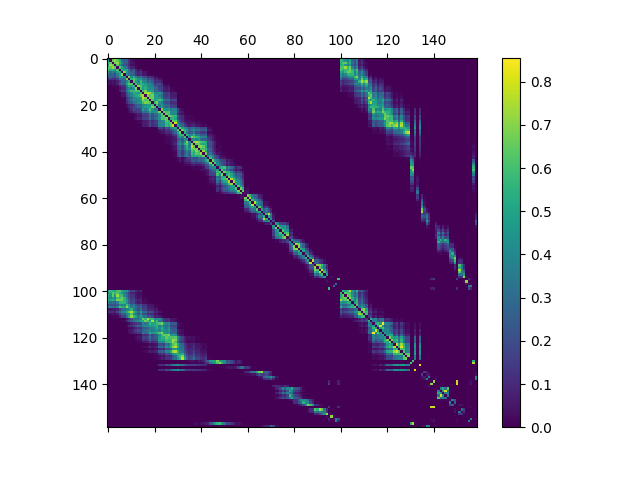

In [14]:
si.plot_template_similarity(analyzer_in_folder)

In [15]:
%matplotlib widget
si.plot_amplitudes(analyzer_in_folder, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

In [16]:
si.plot_unit_waveforms(analyzer_in_folder, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [17]:
si.plot_all_amplitudes_distributions(analyzer_in_folder)

In [18]:
si.plot_quality_metrics(analyzer_in_folder, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

# Export

We are trying to improve `export` options for the `SortingAnalyzer`. We recently introduced the ability to `export_to_pynapple` (https://pynapple.org/)

In [19]:
spikes = si.to_pynapple_tsgroup(analyzer_in_folder)
spikes

Index    rate      x       y        z      num_spikes    firing_rate    presence_ratio    ...
-------  --------  ------  -------  -----  ------------  -------------  ----------------  -----
0        16.54376  638.83  -370.19  1.0    16193         16.54          1.0               ...
1        10.97877  785.78  7.17     11.51  10746         10.98          1.0               ...
2        15.61609  762.45  20.38    1.0    15285         15.62          1.0               ...
3        51.06059  779.55  13.39    10.34  49978         51.06          1.0               ...
5        8.47468   792.34  22.38    10.46  8295          8.47           1.0               ...
6        14.83656  739.05  51.73    28.83  14522         14.84          1.0               ...
11       5.11341   798.47  75.08    1.0    5005          5.11           1.0               ...
...      ...       ...     ...      ...    ...           ...            ...               ...
468      29.31759  794.04  2081.06  1.0    28696         2

Another export option is `export_report`. This creates a nice little report about all your units:

In [25]:
si.export_report(analyzer_in_folder, output_folder=results_folder / "report")